# What is the most optimal skill to learn for Data Analysts?

#### Methodology

1. Continue from last notebook to find percent of postings with skill
2. Visualize median salary vs percent skill demand
3. Determine if certain technologies are more prevalent

## Import Libraries and Data

Import the libraries, data and change the `job_posted_date` to a datetime type.

In [2]:
# Import libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

## Clean Data

Filters the original dataset to only get rows where the job title is 'Data Analyst' and the country is 'United States', to create a new DataFrame `df_DA_DE`. Drop NaN values from the 'salary_year_avg' column. Then it uses the `explode` method on the `job_skills` column to create a new row in a new DataFrame (`df_DA_DE_exploded`) for each skill associated with a job. Finally, it displays the first 5 entries of the `salary_year_avg` and `job_skills` columns.

In [3]:
# filter and making copy of df assigning to new df
df_DA_DE = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'Germany')].copy() 

In [4]:
df_DA_DE = df_DA_DE.dropna(subset=['salary_year_avg'])

df_DA_DE_exploded = df_DA_DE.explode('job_skills')

df_DA_DE_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
20066,75067.5,r
20066,75067.5,python
20066,75067.5,java
20066,75067.5,c#
20066,75067.5,sql


## Calculate Percent of Job Postings that Have Skills

Group the data by job skills and calculates the count and median salary for each skill, sorting the results in descending order by count. It then renames the columns. Calculates the percentage that each skill count represents out of the total number of Data Analyst jobs. Finally, filter out any skills that don't have any jobs associated with them.

In [5]:
df_DA_skills = df_DA_DE_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

DA_job_count = len(df_DA_DE)

df_DA_skills['skill_percent'] = df_DA_skills['skill_count'] / DA_job_count * 100



## Median Salary vs Percent Skill Demand

Filters for Data Analyst skills that exceed a certain percentage (`skill_percent`).

In [6]:
skill_percent = 5

df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_percent]

df_DA_skills_high_demand

,skill_count,median_salary,skill_percent
job_skills,,,
sql,24,101500.0,50.000000
python,18,111175.0,37.500000
tableau,13,100500.0,27.083333
spark,7,111175.0,14.583333
r,7,75067.5,14.583333
excel,7,105650.0,14.583333
looker,5,53014.0,10.416667
power bi,4,83937.5,8.333333
go,4,52014.0,8.333333


Create a scatter plot to visualize the relationship between the percentage of Data Analyst jobs that require specific skills and the median salary for those skills.

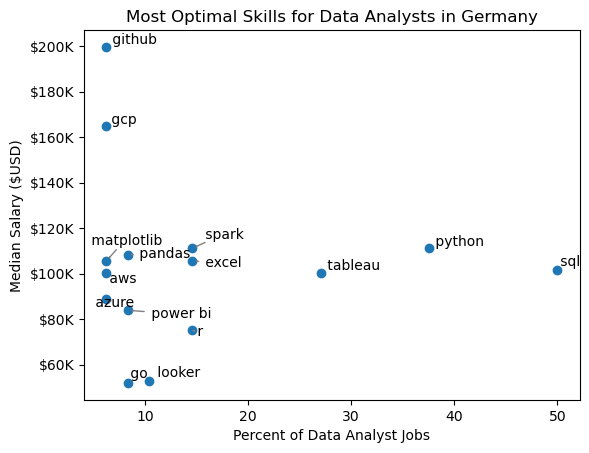

In [7]:
from adjustText import adjust_text

plt.scatter(df_DA_skills_high_demand['skill_percent'], df_DA_skills_high_demand['median_salary'])
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Salary ($USD)')  # Assuming this is the label you want for y-axis
plt.title('Most Optimal Skills for Data Analysts in Germany')

# Get current axes, set limits, and format axes
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))  # Example formatting y-axis

# Add labels to points and collect them in a list
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], " " + txt))

# Adjust text to avoid overlap and add arrows
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

plt.show()

## Colouring by Technology

Adding color labels based on technology.

Removes duplicate entries and any rows with missing values. Then, it combines all dictionary entries into a single dictionary, summing values for keys that repeat across entries. To ensure each key's values are unique, it converts the values to a set and then back to a list. The final result is a dictionary where each key represents a skill and each value is a list of unique attributes associated with that skill.

In [8]:
df['job_type_skills'].sample(10)

244664                                                 None
442389    {'cloud': ['aws'], 'programming': ['python', '...
498513    {'analyst_tools': ['tableau'], 'programming': ...
612853        {'cloud': ['aws'], 'programming': ['python']}
325485                             {'programming': ['sql']}
406164                                                 None
676321    {'cloud': ['bigquery'], 'databases': ['mysql']...
705201                        {'programming': ['r', 'sql']}
41947     {'cloud': ['azure'], 'libraries': ['spark', 'p...
44128                                                  None
Name: job_type_skills, dtype: object

Here in this part of code we first want to check `df['job_type_skills']`, if necessary clean up data from duplicates and NaN values.

In [9]:
df_technology = df['job_type_skills'].copy()
# test NaN values
# Boolean Series where True indicates NaN
nan_mask = df_technology.isna()

# Show how many and optionally list them
print(f"Number of NaN values: {nan_mask.sum()}")
nan_indices = df_technology[nan_mask].index.tolist()

# test duplicates
# Convert each value (dict or None) to a string representation
df_technology_str = df_technology.astype(str)

# Boolean Series: True for duplicates
duplicate_mask = df_technology_str.duplicated()

# Count and list of duplicates
print(f"Number of duplicates: {duplicate_mask.sum()}")
duplicate_indices = df_technology[duplicate_mask].index.tolist()


Number of NaN values: 117037
Number of duplicates: 608178


In [10]:

df_technology = df_technology.dropna()
df_technology = df_technology.drop_duplicates()

technology_dict = {}
for row in df_technology:
  row_dict = ast.literal_eval(row) # converting string to dict
  for key, value in row_dict.items():
    if key not in technology_dict:
      technology_dict[key] = value
    else:
      technology_dict[key] += value

# remove duplicates inside individual keys
for key, value in technology_dict.items():
  technology_dict[key] = list(set(value))

technology_dict

{'analyst_tools': ['visio',
  'nuix',
  'ssis',
  'ms access',
  'sas',
  'msaccess',
  'excel',
  'splunk',
  'powerpoint',
  'dax',
  'microstrategy',
  'spreadsheet',
  'qlik',
  'sap',
  'datarobot',
  'tableau',
  'spss',
  'sharepoint',
  'looker',
  'alteryx',
  'esquisse',
  'outlook',
  'sheets',
  'cognos',
  'word',
  'powerbi',
  'ssrs',
  'power bi'],
 'programming': ['golang',
  'matlab',
  'powershell',
  'apl',
  'perl',
  'pascal',
  'assembly',
  'sql',
  'c',
  'bash',
  'sas',
  'sass',
  'c#',
  'erlang',
  'nosql',
  'dart',
  'vb.net',
  'go',
  'scala',
  'python',
  'lua',
  'julia',
  'lisp',
  'swift',
  'ruby',
  'mongodb',
  'crystal',
  'groovy',
  'kotlin',
  'c++',
  'html',
  'mongo',
  'cobol',
  'shell',
  'visualbasic',
  'elixir',
  'haskell',
  'php',
  't-sql',
  'css',
  'delphi',
  'ocaml',
  'javascript',
  'visual basic',
  'objective-c',
  'clojure',
  'java',
  'typescript',
  'fortran',
  'solidity',
  'rust',
  'f#',
  'vba',
  'no-sql',
 

In [11]:
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,visio
0,analyst_tools,nuix
0,analyst_tools,ssis
0,analyst_tools,ms access
0,analyst_tools,sas
...,...,...
9,sync,webex
9,sync,mattermost
9,sync,slack
9,sync,zoom


Merges two DataFrames, `df_DA_skills` and `df_technology`, based on the columns 
'job_skills' and 'skills' respectively, creating a new DataFrame `df_DA_skills_tech`.

In [12]:
df_DA_skills_tech = df_DA_skills.merge(df_technology, left_on='job_skills', right_on='skills')

df_DA_skills_tech

,skill_count,median_salary,skill_percent,technology,skills
0,24,101500.00,50.000000,programming,sql
1,18,111175.00,37.500000,programming,python
2,13,100500.00,27.083333,analyst_tools,tableau
3,7,111175.00,14.583333,libraries,spark
4,7,75067.50,14.583333,programming,r
5,7,105650.00,14.583333,analyst_tools,excel
6,5,53014.00,10.416667,analyst_tools,looker
7,4,83937.50,8.333333,analyst_tools,power bi
8,4,52014.00,8.333333,programming,go
9,4,108412.50,8.333333,libraries,pandas


In [13]:
df_DA_skills_tech_high_demand = df_DA_skills_tech[df_DA_skills_tech['skill_percent'] > skill_percent]

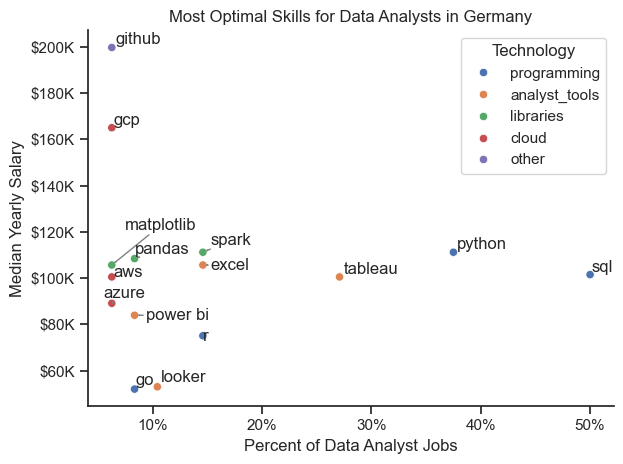

In [15]:
sns.scatterplot(
    data=df_DA_skills_tech_high_demand,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

sns.despine()
sns.set_theme(style='ticks')

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in Germany')
plt.legend(title='Technology')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Adjust layout and display plot 
plt.tight_layout()
plt.show()